In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

plt.rcParams['font.size'] = 14

In [2]:
batch_size = 32
img_size = 224
directory = '/kaggle/input/animals10/raw-img'

datagen = ImageDataGenerator(rescale = 1/255.,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.15)

train_generator = datagen.flow_from_directory(directory,
                                             target_size = (img_size, img_size),
                                             batch_size = batch_size,
                                             shuffle=True,
                                             subset='training',
                                             class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(directory,
                                             target_size = (img_size, img_size),
                                             batch_size = batch_size,
                                             shuffle=False,
                                             subset='validation',
                                             class_mode = 'categorical')


Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [3]:
# train_generator.__dict__
# train_generator.class_indices
[key for key in train_generator.class_indices]


['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

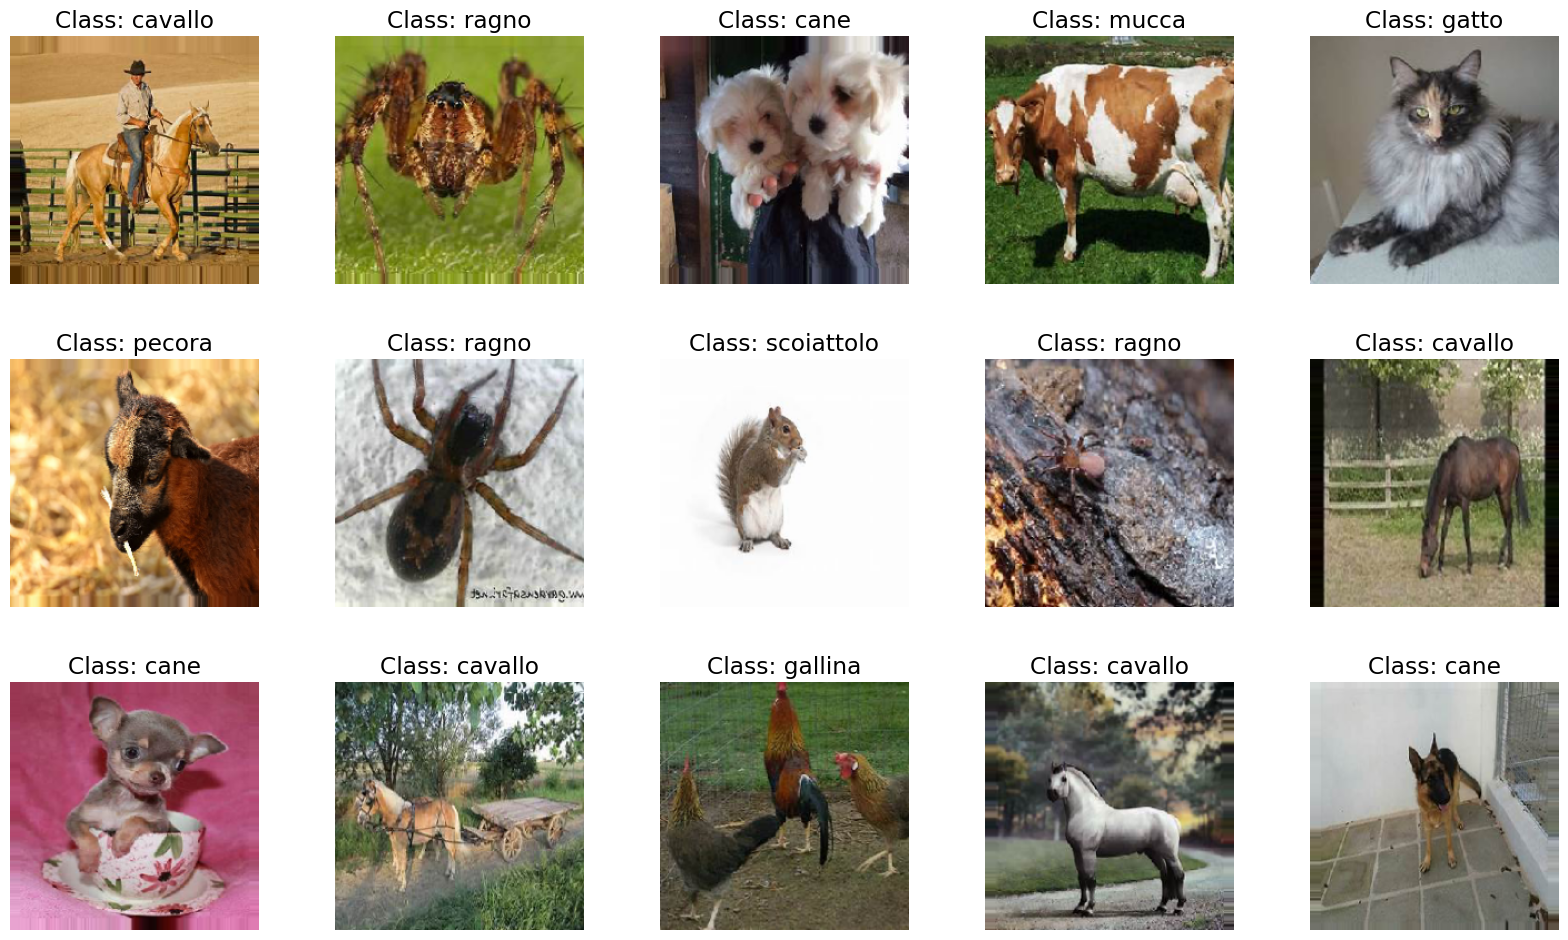

In [4]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

 

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

VGG16

In [5]:
img_size = 224
base_model = VGG16(include_top = False,   # include_top is to include the classifier layer; whether to include the 3 fully-connected layers at the top of the network
                  weights = 'imagenet',
                  input_shape = (img_size, img_size, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [6]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Freezing the bottom layers

In [7]:
base_model.layers

In [8]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

When we set a lr and convergence is slow, increase lr

reduce lr when the convergence is a plateau

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
model_name = 'model.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

In [12]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(10, activation = 'softmax')(x)
model = Model(inputs = base_model.inputs, outputs = outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [13]:
history = model.fit(train_generator,
                   epochs = 10,
                   validation_data = validation_generator,
                   callbacks = [checkpoint, earlystopping])

Epoch 1/10
696/696 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7735
Epoch 1: val_loss improved from inf to 0.45319, saving model to model.h5
696/696 [==============================] - 470s 660ms/step - loss: 0.6850 - accuracy: 0.7735 - val_loss: 0.4532 - val_accuracy: 0.8496
Epoch 2/10
696/696 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8869
Epoch 2: val_loss improved from 0.45319 to 0.30926, saving model to model.h5
696/696 [==============================] - 342s 491ms/step - loss: 0.3424 - accuracy: 0.8869 - val_loss: 0.3093 - val_accuracy: 0.8978
Epoch 3/10
696/696 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9183
Epoch 3: val_loss did not improve from 0.30926
696/696 [==============================] - 336s 484ms/step - loss: 0.2538 - accuracy: 0.9183 - val_loss: 0.3108 - val_accuracy: 0.8975
Epoch 4/10
696/696 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9369
Epoch 4: val_l

Epoch 00010: val_loss did not improve from 0.22283
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping